Imports

In [67]:
import easy_scpi as scpi
import pyvisa
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import time
import regex as re


In [2]:
def convert_to_binary_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Convert the image to grayscale
    image = image.convert('L')

    # Threshold the image to convert pixel values to either 0 or 255
    threshold = 64
    image = image.point(lambda p: p > threshold and 255)

    # Convert the image to binary by dividing by 255
    image = image.point(lambda p: p // 255)

    return image

print(convert_to_binary_image('poster.jpeg'))

<PIL.Image.Image image mode=L size=205x126 at 0x7F3B59526B60>


save image

Conversion completed. x_coordinates.arb and y_coordinates.arb files generated.


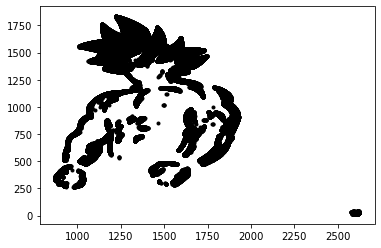

In [3]:


def convert_image_to_arb(image_path):
    # Load the image and convert it to black and white
    image = convert_to_binary_image(image_path)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Get the coordinates of black pixels (where pixel value is 0)
    black_pixel_indices = np.argwhere(image_array == 1)

    # Check if there are any black pixels
    if len(black_pixel_indices) == 0:
        print("No black pixels found in the image.")
        return np.array([], dtype=np.int16), np.array([], dtype=np.int16)

    # Extract x and y coordinates from black pixel indices
    x_coordinates, y_coordinates = black_pixel_indices[:, 1].astype(
        np.int16), (image_array.shape[0] - black_pixel_indices[:, 0] - 1).astype(np.int16)

    # Write the x and y coordinates to separate .arb files
    np.savetxt('x_coordinates.arb', x_coordinates, fmt='%d')
    np.savetxt('y_coordinates.arb', y_coordinates, fmt='%d')

    print("Conversion completed. x_coordinates.arb and y_coordinates.arb files generated.")

    # Plot the image from x and y coordinates
    plt.scatter(x_coordinates, y_coordinates, marker='.', color='black')

    return x_coordinates, y_coordinates

    


# Provide the path to your image
image_path = 'goku.jpg'

# Convert the image to ARB files
X,Y = convert_image_to_arb(image_path)




Reorder for better readability

In [4]:
'''
# Read x and y coordinates from separate files
x_coords = X
y_coords = Y

# Create distance matrix as a sparse matrix
num_points = len(x_coords)
row = []
col = []
data = []

print("computing distance matrix")
for i in range(num_points):
    for j in range(i + 1, num_points):
        distance = np.sqrt((x_coords[j] - x_coords[i])
                           ** 2 + (y_coords[j] - y_coords[i])**2)
        row.append(i)
        col.append(j)
        data.append(distance)

distance_matrix = coo_matrix(
    (data, (row, col)), shape=(num_points, num_points))

print("Linear sum assignment")
# Solve TSP using the Held-Karp algorithm
row_ind, col_ind = linear_sum_assignment(distance_matrix.toarray())

print("getting optimal order")
# Get the optimal order of visiting the points
optimal_order = col_ind.tolist()

print("plotting")
# Plot the points and the resulting tour
plt.scatter(x_coords, y_coords, color='black')
#plt.plot(x_coords[optimal_order + [optimal_order[0]]],
#    y_coords[optimal_order + [optimal_order[0]]], color='red')
plt.show()

# Write the optimal x and y cords to a file
np.savetxt('optimal_x_coordinates.arb', x_coords[optimal_order], fmt='%d')
np.savetxt('optimal_y_coordinates.arb', y_coords[optimal_order], fmt='%d')

print("Conversion completed. optimal_x_coordinates.arb and optimal_y_coordinates.arb files generated.")

#plot optimal order
plt.scatter(x_coords[optimal_order], y_coords[optimal_order], color='black')
'''

'\n# Read x and y coordinates from separate files\nx_coords = X\ny_coords = Y\n\n# Create distance matrix as a sparse matrix\nnum_points = len(x_coords)\nrow = []\ncol = []\ndata = []\n\nprint("computing distance matrix")\nfor i in range(num_points):\n    for j in range(i + 1, num_points):\n        distance = np.sqrt((x_coords[j] - x_coords[i])\n                           ** 2 + (y_coords[j] - y_coords[i])**2)\n        row.append(i)\n        col.append(j)\n        data.append(distance)\n\ndistance_matrix = coo_matrix(\n    (data, (row, col)), shape=(num_points, num_points))\n\nprint("Linear sum assignment")\n# Solve TSP using the Held-Karp algorithm\nrow_ind, col_ind = linear_sum_assignment(distance_matrix.toarray())\n\nprint("getting optimal order")\n# Get the optimal order of visiting the points\noptimal_order = col_ind.tolist()\n\nprint("plotting")\n# Plot the points and the resulting tour\nplt.scatter(x_coords, y_coords, color=\'black\')\n#plt.plot(x_coords[optimal_order + [optimal

**Connecting to Instruments**

In [29]:
# Identify the VISA resource address of your instrument
rm = pyvisa.ResourceManager()
rm.list_resources()


('ASRL/dev/ttyS4::INSTR',
 'ASRL/dev/ttyS0::INSTR',
 'ASRL/dev/ttyUSB2::INSTR',
 'ASRL/dev/ttyUSB1::INSTR',
 'ASRL/dev/ttyUSB0::INSTR',
 'USB0::10893::6008::MY55280196::0::INSTR',
 'USB0::2391::1560::MY51260020::0::INSTR')

*init addresses*

In [80]:
WAVEGEN_USBIP = 'USB0::2391::11271::MY57801065::0::INSTR'
SCOPE_USBIP = 'USB0::10893::6008::MY55280196::0::INSTR'
DMM_USBIP = 'USB0::2391::1560::MY51260020::0::INSTR'

# Connect to the waveform generator and the oscilloscope
rm = pyvisa.ResourceManager()


*Connect and query the scope*

In [77]:
#connect to scope
scope = rm.open_resource(SCOPE_USBIP)
print("Connected to Scope")

#query scope
scope.write('SYST:REM')
print("Name " +scope.query('*IDN?'))

# Perform autoscale
scope.write(':AUToscale')

# Wait for the autoscale to complete
time.sleep(5)

# Save a screenshot as an image file
scope.write(':DISPlay:DATA? PNG, COLor')
screenshot_data = scope.read_raw()

# Extract the image data from the screenshot data
image_data_match = re.search(
    rb'(\x89PNG[\x00-\xFF]+\x49\x45\x4E\x44\xAE\x42\x60\x82)', screenshot_data)
if image_data_match:
    image_data = image_data_match.group(0)
else:
    raise ValueError("Unable to extract image data from screenshot data.")

# Save the image file
screenshot_file = 'screenshot.png'
with open(screenshot_file, 'wb') as file:
    file.write(image_data)
    
#show the scheenshot_data
img = Image.open('screenshot.png')
img.show()


#close the scope
scope.close()


Connected to Scope
Name KEYSIGHT TECHNOLOGIES,MSO-X 3014T,MY55280196,07.40.2021031200



*Connect to Wavegen in Scope*

In [97]:
#connect to scope
scope = rm.open_resource(SCOPE_USBIP)
print("Connected to Scope")

#query scope
scope.write('SYST:REM')
print("Name " +scope.query('*IDN?'))

# Enable the built-in waveform generator
scope.write(':FUNCtion:GENerator ON')
print("Waveform generator enabled")

# Configure the waveform generator to output a sine wave
scope.write(':OUTPUT:FUNCTION SIN')
scope.write(':OUTPUT:STATE ON')
scope.write(':OUTPUT:FREQUENCY 1000')  # Set the frequency to 1000 Hz
scope.write(':OUTPUT:VOLTAGE:AMPLITUDE 1')  # Set the amplitude to 1 V
print("Waveform generator configured")

scope.write(':AUToscale')
time.sleep(5)

# Close the oscilloscope connection
scope.close()

Connected to Scope
Name KEYSIGHT TECHNOLOGIES,MSO-X 3014T,MY55280196,07.40.2021031200

Waveform generator enabled
Waveform generator configured


*Connect and Query DMM*

In [81]:
#Connect to DMM
dmm = rm.open_resource(DMM_USBIP)
print("Connected to DMM")

# Set the timeout and read termination characters
dmm.timeout = 5000  # 5 seconds
dmm.read_termination = '\n'

#query DMM
dmm.write('SYST:REM')
print("Name" + dmm.query('*IDN?'))

# Configure the DMM for voltage measurement
print("----------Measuring Voltage----------")
dmm.write('CONF:VOLT:DC')
time.sleep(.2)  # Wait for configuration to take effect
voltage = float(dmm.query('READ?'))
print(f"Voltage: {voltage} V")

# Configure the DMM for resistance measurement
print("----------Measuring Resistance----------")
dmm.write('CONF:RES')
time.sleep(.2)  # Wait for configuration to take effect
resistance = float(dmm.query('READ?'))
print(f"Resistance: {resistance} Ohm")

# Close the connection to the DMM
dmm.close()


Connected to DMM
NameAgilent Technologies,34405A,MY51260020,1.50-3.14
----------Measuring Voltage----------
Voltage: 1.8e-05 V
----------Measuring Resistance----------
Resistance: 9.9e+37 Ohm


*Connect and Query Waveform Generator*

In [87]:
#connect to wavegen
wavegen = rm.open_resource(WAVEGEN_USBIP, write_termination='\n', read_termination='\n', timeout=5000)
print("Connected to wavegen.")


Connected to wavegen.


In [92]:
#query wavegen
wavegen.write('SYST:REM')
print(wavegen.write('*RST'))
print(wavegen.query('*IDN?'))


ValueError: [Errno 110] Operation timed out

In [86]:
wavegen.close()